# Python GroupBy tricks
See [Medium article](todo).

Data set: [Credit Card Approval prediction](https://www.kaggle.com/caesarmario/application-data)

## Loading in the dataset
We'll load in the dataset using Python's standard library `csv` module to read in the csv data.
To show a sample of the data, I'm using the [`prettytable` package](https://github.com/jazzband/prettytable).

In [9]:
import os
import csv
from prettytable import PrettyTable

DATA_FILE_NAME = "data.csv"
file_path = os.path.join(os.path.dirname(__name__), DATA_FILE_NAME)

with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    field_names = list(reader.fieldnames)
    data = [row for row in reader]

print(field_names)
t = PrettyTable(field_names)
t.add_rows(row.values() for row in data[:5])
print(len(data))


['Applicant_ID', 'Applicant_Gender', 'Owned_Car', 'Owned_Realty', 'Total_Children', 'Total_Income', 'Income_Type', 'Education_Type', 'Family_Status', 'Housing_Type', 'Owned_Mobile_Phone', 'Owned_Work_Phone', 'Owned_Phone', 'Owned_Email', 'Job_Title', 'Total_Family_Members', 'Applicant_Age', 'Years_of_Working', 'Total_Bad_Debt', 'Total_Good_Debt', 'Status']
25128


We can see that the data contains the following parameters:
* `Applicant_ID`
* `Applicant_Gender`
* `Owned_Car`
* `Owned_Realty`
* `Total_Children`
* `Total_Income`
* `Income_Type`
* `Education_Type`
* `Family_Status`
* `Housing_Type`
* `Owned_Mobile_Phone`
* `Owned_Work_Phone`
* `Owned_Phone`
* `Owned_Email`
* `Job_Title`
* `Total_Family_Members`
* `Applicant_Age`
* `Years_of_Working`
* `Total_Bad_Debt`
* `Total_Good_Debt`
* `Status`

Let's do some `groupby` operations to showcase the function.

In [10]:
import itertools
from collections.abc import Iterator

def create_dict_from_groupby(iterator: Iterator) -> dict:
    """
    Captures the groupby result in a dict so 
    it can be reused multiple times
    """
    groupby_dict = {}
    for key, group in iterator:
        groupby_dict[key] = list(group)
    return groupby_dict

total_children = lambda row: row["Total_Children"]
# first sort by the total children
sorted_by_children = sorted(data, key=total_children)
# groupby the total children
groupby_children_iter = itertools.groupby(sorted_by_children, key=total_children)
groupby_children = create_dict_from_groupby(groupby_children_iter)

Text(0.5, 0, 'Total children of applicants')

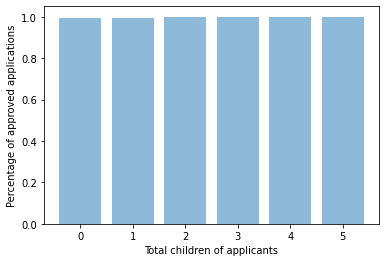

In [11]:
import matplotlib.pyplot as plt
def appl_granted_percentage(group) -> float:
    grants = sum(int(row['Status']) for row in group)
    return grants / len(group)
y_range = list(groupby_children.keys())
grants = [appl_granted_percentage(group) for group in groupby_children.values()]

plt.bar(y_range, grants, align='center', alpha=0.5)
plt.ylabel('Percentage of approved applications')
plt.xlabel('Total children of applicants')


## Finding repeated groups by not sorting
Let's group by housing type to see if there are any repeated groups in the dataset

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

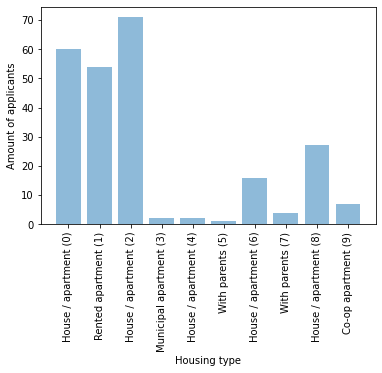

In [12]:
def create_tuples_from_groupby(iterator) -> list[tuple[str, list]]:
    groupby_list = []
    for key, group in iterator:
        groupby_list.append((key, list(group)))
    return groupby_list
        
groupby_housing_type_iter = itertools.groupby(data, key=lambda row: row["Housing_Type"])
groupby_housing = create_tuples_from_groupby(groupby_housing_type_iter)

y_range = [f"{str(entry[0]).strip()} ({i})" for i, entry in enumerate(groupby_housing[:10])]
amount_in_group = [len(entry[1]) for entry in groupby_housing[:10]]
plt.bar(y_range, amount_in_group, align='center', alpha=0.5)
plt.ylabel('Amount of applicants')
plt.xlabel('Housing type')
plt.xticks(rotation=90)


As we can see, there are returning groups such as House / Appartment. From the amount of applicants in each group, it's clear that the dataset isn't very randomly balanced.

## Accessing group properties using `dataclasses`
When using `groupby` you have to provide a key function that extracts the property of each entry in the iterable that you want to form groups on. If you want to group on a single property, you'll often see that this is a simple lambda function that retrieves this property.

In [13]:
groupby_housing_type_iter = itertools.groupby(data, key=lambda row: row["Housing_Type"])

But what if you want to group by multiple values? You could create a string or a hash of both the properties you're grouping on. Let's say we're grouping on `Housing Type` and `Total Children` as before, we can implement this as follows:

In [14]:
groupby_housing_children = itertools.groupby(data, key=lambda row: f"{row['Housing_Type']}_{row['Total_Children']}")
for key, group in groupby_housing_children:
    housing_type = key.split('_')[0] # Access housing type through string formatting on the key
    total_children = next(iter(group))['Total_Children'] # Access total children from the first group member
    print(f"Housing type: {housing_type}, total children: {total_children}")

Housing type: House / apartment                                 , total children: 0
Housing type: House / apartment                                 , total children: 3
Housing type: House / apartment                                 , total children: 1
Housing type: House / apartment                                 , total children: 0
Housing type: House / apartment                                 , total children: 2
Housing type: House / apartment                                 , total children: 1
Housing type: House / apartment                                 , total children: 0
Housing type: House / apartment                                 , total children: 2
Housing type: Rented apartment                                  , total children: 0
Housing type: House / apartment                                 , total children: 0
Housing type: House / apartment                                 , total children: 2
Housing type: House / apartment                                 , total chil

This code works well enough but fails when you need to access the properties of the group key later down the line. You'll either have to resort to string parsing or getting one of the group members and reading its properties, neither of which are particularly graceful.


We can solve this by making a more complex key function that returns a custom object instead. The only prerequisite for groupbyis that the object is comparable. Because custom objects compare by memory reference by default, we'd need to implement our own __eq__ function to have different objects compare equally. Luckily, the dataclasses package of the standard library includes functionality that does this for us. Providing eq=True to the dataclass decorator dataclasses will generate a __eq__ method that compares objects based on their properties, exactly what we need! I also like to add frozen=True to make the group key immutable.

In [15]:
from dataclasses import dataclass

@dataclass(eq=True, frozen=True)
class HousingTypeTotalChildren:
    housing_type: str
    total_children: int

    @classmethod
    def from_row(cls, row: dict) -> "HousingTypeTotalChildren":
        return cls(housing_type=row['Housing_Type'], total_children=int(row['Total_Children']))


In [16]:
group_by_housing_children = itertools.groupby(data, key=HousingTypeTotalChildren.from_row)
for key, group in group_by_housing_children:
    # Access group properties directly from the key
    access_props = f"Housing type: {key.housing_type}, Total children: {key.total_children}"